# Question 3
### What is the influence of weather on trip duration? Weather is examined by average temperature, precipitation, and average wind speed.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-white')
# Import ML packages
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.datasets import load_nfl
from yellowbrick.datasets import load_credit
from yellowbrick.datasets import load_hobbies
from sklearn.datasets import make_blobs

### Process 3.1 -- Load Dataset
Firstly, we have to reload datasets

In [3]:
# Read weather csv file
weather = pd.read_csv("pit_weather.csv")
# Select only 5 columns from the initial dataset
weather = weather[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN']]
# Calculate the average temperature of the day
weather['TAVG'] = weather[['TMAX', 'TMIN']].mean(axis=1)
# Show if there are any missing values
weather.info()
# However, we will not drop the NaN values now for the convenience of merging dataset
weather.isnull().sum(axis=0)
# Print the first 5 rows of the dataset
weather.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    1095 non-null   object 
 1   AWND    1092 non-null   float64
 2   PRCP    1094 non-null   float64
 3   TMAX    1093 non-null   float64
 4   TMIN    1093 non-null   float64
 5   TAVG    1093 non-null   float64
dtypes: float64(5), object(1)
memory usage: 51.5+ KB


,DATE,AWND,PRCP,TMAX,TMIN,TAVG
0,2017-01-01,5.82,0.03,44.0,32.0,38.0
1,2017-01-02,7.16,0.09,46.0,36.0,41.0
2,2017-01-03,6.93,0.76,50.0,42.0,46.0
3,2017-01-04,15.66,0.04,45.0,21.0,33.0
4,2017-01-05,8.72,0.06,23.0,18.0,20.5


In [5]:
# Load riding data sets
ride = pd.DataFrame(data = None)
for i in range(7,10):
    for j in range(1,5):
        ride_1 = pd.read_csv("healthy-ride-rentals-201{}-q{}.csv".format(i, j))
        # drop the lines with NA
        ride_1 = ride_1.dropna(axis=0)
        # copy the column with date
        ride_1["tmp"] = ride_1["Starttime"]
        # starttime and stoptime delete the date
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: str(x).split(" ")[1])
        # convert starttime to minutes
        ride_1["Starttime"] = ride_1["Starttime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: str(x).split(" ")[1])
        # convert stoptime to minutes
        ride_1["Stoptime"] = ride_1["Stoptime"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))
        # extract date to a new column and then merge with weather dataset
        ride_1["DATE"] = ride_1["tmp"].apply(lambda x: str(str(x).split("/")[2]).split(" ")[0] + "-" + str(x).split("/")[0]+ "-"  + str(x).split("/")[1])
        # adjust the format
        ride_1["DATE"] = pd.to_datetime(ride_1["DATE"]).apply(lambda x: str(x).split(" ")[0])
        # delete the temp column
        del ride_1["tmp"]

        # add each subdataset
        ride = pd.concat([ride, ride_1])
ride.head(5)

/Users/nellyan45/.conda/envs/untitled/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Trip id,Starttime,Stoptime,Bikeid,Tripduration,From station id,From station name,To station id,To station name,Usertype,DATE
0,25723960.0,508,510,70478.0,110.0,1043.0,S Millvale Ave & Centre Ave,1044.0,Zulema St & Coltart Ave,Subscriber,2017-01-01
1,25724207.0,593,600,70439.0,426.0,1014.0,Ridge Ave & Brighton Rd (CCAC),1012.0,North Shore Trail & Fort Duquesne Bridge,Customer,2017-01-01
2,25724297.0,621,646,70440.0,1498.0,1019.0,42nd St & Butler St,1012.0,North Shore Trail & Fort Duquesne Bridge,Subscriber,2017-01-01
3,25724391.0,663,690,70002.0,1581.0,1019.0,42nd St & Butler St,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01
4,25724479.0,703,729,70024.0,1563.0,1018.0,Butler St & Stanton Ave,1013.0,Isabella St & Federal St (PNC Park),Customer,2017-01-01


In [6]:
# Merge ride dataframe with weather dataframe based on DATE
df_merged = pd.merge(ride, weather, on='DATE')
df_merged.info()
# Show how many rows have empty values
df_merged.isnull().sum(axis=0)
# Drop rows which contain NaN values
df_merged = df_merged.dropna()
# Drop not useful columns
df_merged = df_merged.drop(['Trip id', 'Bikeid','From station name', 'To station name'], axis=1)
# Convert Usertype from categorical to dummy variable 0(customer) and 1(subscriber)
df_merged['Usertype'] = df_merged['Usertype'].astype('category').cat.codes
# Drop the date column, since it is not continuous variables
df_merged = df_merged.drop(['DATE'], axis=1)
# Show top 5 rows of the dataset
df_merged.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227290 entries, 0 to 227289
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Trip id            227290 non-null  float64
 1   Starttime          227290 non-null  int64  
 2   Stoptime           227290 non-null  int64  
 3   Bikeid             227290 non-null  float64
 4   Tripduration       227290 non-null  float64
 5   From station id    227290 non-null  float64
 6   From station name  227290 non-null  object 
 7   To station id      227290 non-null  float64
 8   To station name    227290 non-null  object 
 9   Usertype           227290 non-null  object 
 10  DATE               227290 non-null  object 
 11  AWND               227006 non-null  float64
 12  PRCP               226736 non-null  float64
 13  TMAX               227215 non-null  float64
 14  TMIN               227215 non-null  float64
 15  TAVG               227215 non-null  float64
dtypes:

,Starttime,Stoptime,Tripduration,From station id,To station id,Usertype,AWND,PRCP,TMAX,TMIN,TAVG
0,508,510,110.0,1043.0,1044.0,1,5.82,0.03,44.0,32.0,38.0
1,593,600,426.0,1014.0,1012.0,0,5.82,0.03,44.0,32.0,38.0
2,621,646,1498.0,1019.0,1012.0,1,5.82,0.03,44.0,32.0,38.0
3,663,690,1581.0,1019.0,1013.0,0,5.82,0.03,44.0,32.0,38.0
4,703,729,1563.0,1018.0,1013.0,0,5.82,0.03,44.0,32.0,38.0


### Process 3.2 -- Create scatter plot visualization for weather and trip duration
This can visually help to understand the distribution of the data of weather and trip duration

Text(0.5, 1.0, 'Scatterplot of average temperature and trip duration')

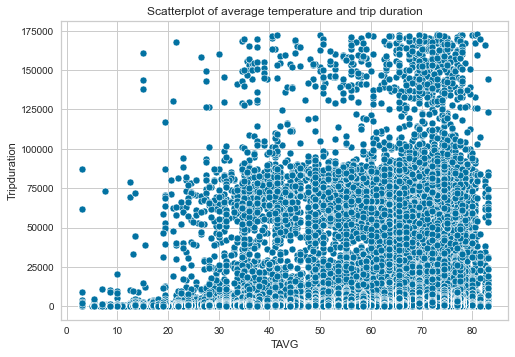

In [7]:
# Create scatterplot of average temperature and trip duration
sns.scatterplot(data=df_merged, x='TAVG', y='Tripduration').set_title('Scatterplot of average temperature and trip duration')

Text(0.5, 1.0, 'Scatterplot of average precipitation and trip duration')

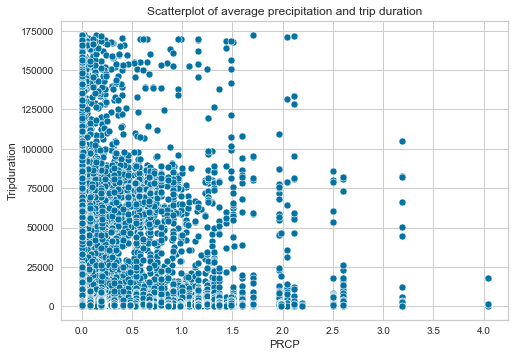

In [8]:
# Create scatterplot of precipitation and trip duration
sns.scatterplot(data=df_merged, x='PRCP', y='Tripduration').set_title('Scatterplot of average precipitation and trip duration')

Text(0.5, 1.0, 'Scatterplot of average wind speed and trip duration')

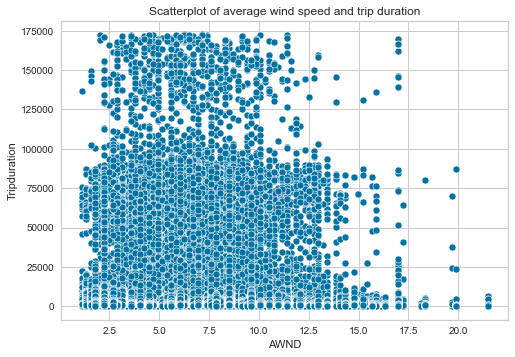

In [9]:
# Create scatterplot of average windspeed and trip duration
sns.scatterplot(data=df_merged, x='AWND', y='Tripduration').set_title('Scatterplot of average wind speed and trip duration')

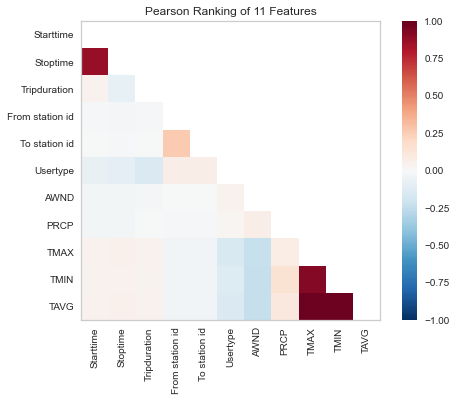

<AxesSubplot:title={'center':'Pearson Ranking of 11 Features'}>

In [10]:
# Create an 2D Pearson ranking graph for all the features in X
from yellowbrick.features import Rank2D
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

visualizer.fit(df_merged)           # Fit the data to the visualizer
visualizer.transform(df_merged)        # Transform the data
visualizer.show()

From the avove Pearson ranking graph for all features, we are able to briefly see the correlation between Tripduration and weather variables (AWND, PRCP, and TAVG). The correlaiton between Tripduration and average wind speed is hitting 0, which indicates not a strong correlation. The correlation between Tripduration and Precipitation is slightly negative, which makes sense, since we expect to see less trips and tripduration if rain more. The correlation between Tripduration and average temperature is positive, which makes sense, since we expect the higher temperatures, more trip duration should be spent since it is not cold.

After knowing this information, now we will perform K-means Clustering by choosing the optimal k.

### Process 3.4 -- Find the optimal K for K-means clustering
Find the optimal K using both of elbow method and Calinski-Harabasz metrics, compare two of them, and decide which one is more optimal

In [11]:
# Create a Kmeans model
model = KMeans(random_state=1)
model.fit(df_merged)

KMeans(random_state=1)

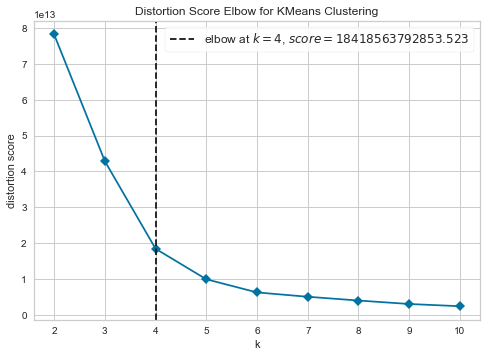

In [45]:
# Run an elbow method from k=2 to k=10 to see which k is the best using elbow method
visualizer = KElbowVisualizer(model, k=(2,11), timings = False)
visualizer.fit(df_merged.values)
visualizer.show();

As shown in the graph above, k = 5 is the optimal k using elbow method.

In [46]:
# Build and fit the K-means clustering using k = 4
model_elbow = KMeans(random_state=1, n_clusters=4).fit(df_merged.values)

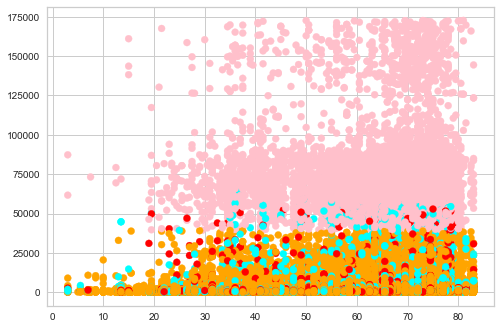

In [47]:
# Create scatterplot of the clustering using varibales TAVG and Triptime to see if that gives insights
colors = np.array(["orange", "red","pink","cyan","purple"])
plt.scatter(df_merged['TAVG'], df_merged['Tripduration'], c=colors[model_elbow.labels_])
plt.show()

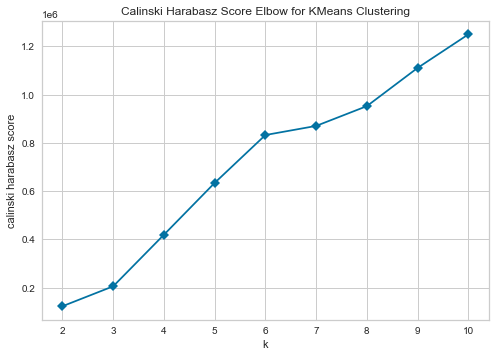

The best k using Calinski Harabasz method is 10


In [48]:
# Run a Calinski Harabasz method from k=2 to k=10 to see which k is the best using Calinski Harabasz method
visualizer = KElbowVisualizer(model, k=(2,11), metric='calinski_harabasz',timings=False, locate_elbow=False)
visualizer.fit(df_merged)
visualizer.show();
# Print out the index of which the Calinski Harabasz score is the highest
print('The best k using Calinski Harabasz method is', visualizer.k_scores_.index(max(visualizer.k_scores_)) + 2)

In [49]:
# Build and fit the K-means clustering using k = 10
model_calinski = KMeans(random_state=1, n_clusters=10).fit(df_merged.values)

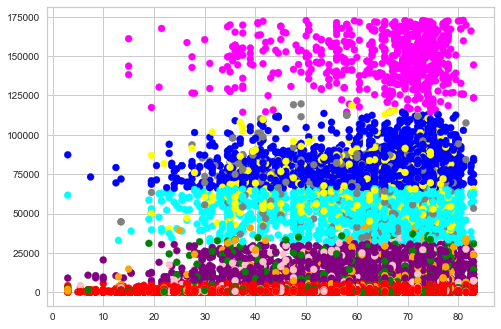

In [50]:
# Create scatterplot of the clustering using varibales TAVG and Triptime to see if that gives insights
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan", "yellow", "grey", "black", "brown", "wheat", "teal", "lime", "olive", "indigo", "gold", "salmon", "seagreen"])
plt.scatter(df_merged['TAVG'], df_merged['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

After finding the best k using elbow and Calinski method, now we need to compare and see which method is better

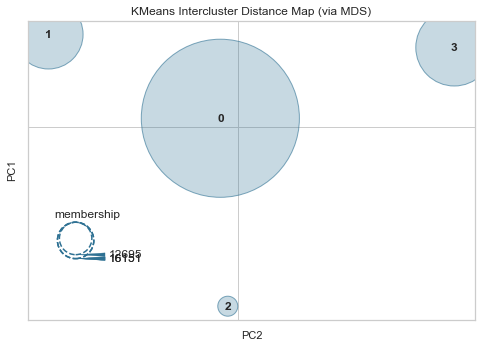

In [51]:
# Create an Intercluster Distance Map for elbow method which K = 4
visualizer = InterclusterDistance(model_elbow, random_state=1)
visualizer.fit(df_merged)
visualizer.show();

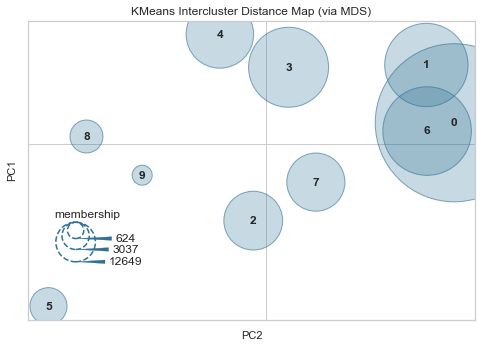

In [52]:
# Create an Intercluster Distance Map for Calinski method which K = 10
visualizer = InterclusterDistance(model_calinski, random_state=1)
visualizer.fit(df_merged)
visualizer.show();

Comparing the InterClusterDistance map between k = 5 and k = 20, we are able to see that K=5 is significantly better. There is no Cluster distance overlaps in k = 5, whereas the cluster distance overlaps by large for k = 20. Therefore, solely looking at these two graphs, it is likely that k = 5 is the better optimal k in this case.

### Process 3.5 -- display the clustering result of tripduration and weather variables using the optimal k

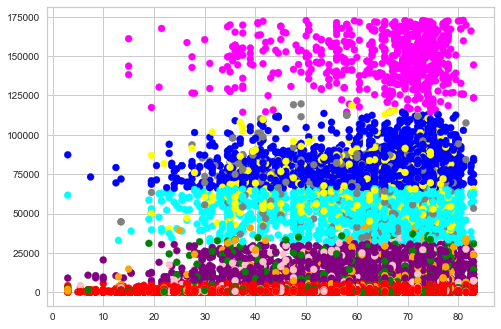

In [53]:
# Create scatterplot of the clustering using TAVG and Tripduration
colors = np.array(["red","green","blue","pink","orange","magenta","purple","cyan", "yellow", "grey", "black", "brown", "wheat", "teal", "lime", "olive", "indigo", "gold", "salmon", "seagreen"])
plt.scatter(df_merged['TAVG'], df_merged['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

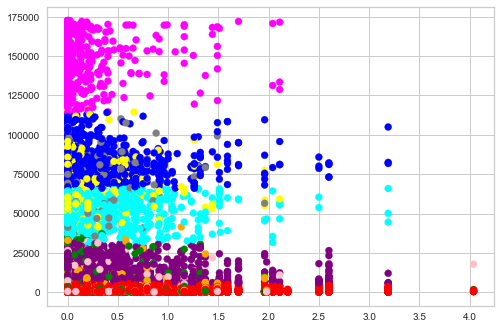

In [54]:
# Create scatterplot of the clustering using varibales TAVG and Tripduration
plt.scatter(df_merged['PRCP'], df_merged['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

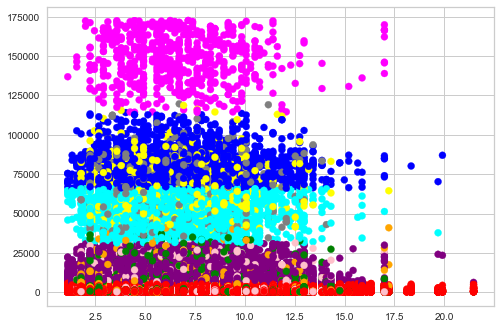

In [55]:
# Create scatterplot of the clustering using varibales TAVG and Tripduration
plt.scatter(df_merged['AWND'], df_merged['Tripduration'], c=colors[model_calinski.labels_])
plt.show()

In [60]:
hc_single=AgglomerativeClustering(n_clusters=5, linkage='single').fit(df_merged)

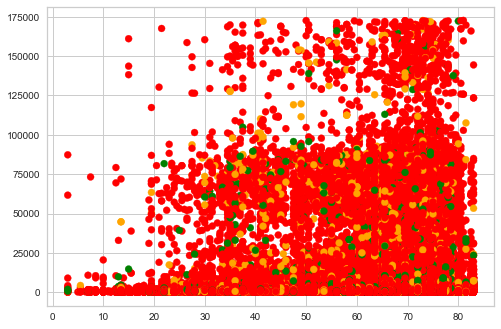

In [61]:
plt.scatter(df_merged['TAVG'], df_merged['Tripduration'], c=colors[hc_single.labels_]);
plt.show();